# **Crop Logos and Augmentation**
Đầu tiên, từ tập ảnh download được ở bước trước, nhóm tiến hành lọc ra các hình ảnh không liên quan và đánh nhãn cho các hình ảnh còn lại. Ở bước này nhóm sẽ cắt các ảnh logo từ tập ảnh có label. Sau đó, nhóm sẽ thực hiện một số phép biến đổi trên các ảnh logo có được từ bước trên để tăng cường thêm dữ liệu.

In [1]:
# Import library
from skimage import io
from skimage import util
from skimage import filters
from skimage import transform
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import os

In [2]:
# Define util functions

def read_all_file_in_dir(in_dir):
  files = []
  for path, dir_names, file_names in os.walk(in_dir):
    files += file_names
    break
  return files

def read_all_dir_in_dir(in_dir):
  dirs = []
  for path, dir_names, file_names in os.walk(in_dir):
    dirs += dir_names
    break
  return dirs

def read_labels(label_dir, img_name):
  labels = []
  f = open(os.path.join(label_dir, img_name + '.txt'))
  for line in f:
    label = [float(x) for x in line.split()]
    labels.append(label)
  f.close()
  return labels

def augment_image(img, out_dir, index=0, ext='png'):
  blurred_img = filters.gaussian(img, 1.5, multichannel=True)
  noised_img = util.random_noise(img, mode='gaussian', var=random.uniform(0.005, 0.05))
  horizontal_resized_img = transform.resize(img, (img.shape[0], int(img.shape[1] * random.uniform(1.2, 2.5))))
  vertical_resized_img = transform.resize(img, (int(img.shape[0] * random.uniform(1.2, 2.5)), img.shape[1]))
  io.imsave(os.path.join(out_dir, f'logo_{index}.{ext}'), util.img_as_ubyte(blurred_img))
  io.imsave(os.path.join(out_dir, f'logo_{index+1}.{ext}'), util.img_as_ubyte(noised_img))
  io.imsave(os.path.join(out_dir, f'logo_{index+2}.{ext}'), util.img_as_ubyte(horizontal_resized_img))
  io.imsave(os.path.join(out_dir, f'logo_{index+3}.{ext}'), util.img_as_ubyte(vertical_resized_img))
  return index + 4

def crop_logo_from_img(img, labels, out_dir, index=0, ext='png', augmented_dir='./dataset/logos/augmented_logos'):
  shape = img.shape
  for label in labels:
    x = label[1] * shape[1]
    y = label[2] * shape[0]
    width = label[3] * shape[1]
    height = label[4] * shape[0]
    logo = img[int(y-height / 2):int(y+height/2), int(x-width/2):int(x+width/2), :]
    io.imsave(os.path.join(out_dir, f'logo_{index}.{ext}'), logo)
    index = augment_image(util.img_as_ubyte(logo), augmented_dir, index=index+1, ext=ext)
  return index

In [3]:
# Dataset directory
img_dir = './dataset/images'
label_dir = './dataset/labels'
logo_dir = './dataset/logos'
labels_file = './dataset/logo_labels.csv'
augmented_logo_dir = './dataset/logos/augmented_logos'

In [4]:
# Create folder to store logos
if not os.path.exists(logo_dir):
  os.mkdir(logo_dir)
if not os.path.exists(augmented_logo_dir):
  os.mkdir(augmented_logo_dir)

In [5]:
# Read child folders in image folder
child_dir_names = read_all_dir_in_dir(img_dir)
logo_labels = []

# Read all images in each child folder
index = 0
for dir_name in child_dir_names:
  child_image_dir = os.path.join(img_dir, dir_name)
  child_label_dir = os.path.join(label_dir, dir_name)

  file_names = read_all_file_in_dir(child_image_dir)
  
  for file_name in file_names:
    ext = file_name.split('.')[-1]
    img = io.imread(os.path.join(child_image_dir, file_name))
    labels = read_labels(child_label_dir, file_name.split('.')[0])
    new_index = crop_logo_from_img(img, labels=labels, out_dir=logo_dir, index=index, ext = ext)
    logo_labels += [[(f'augmented_logos/logo_{x}.{ext}', f'logo_{x}.{ext}')[x % 5 == 0], dir_name, (f'logo_{(x//5)*5}.{ext}', '')[x % 5 == 0]] for x in range(index, new_index)]
    index = new_index

/home/vinhloi/anaconda3/envs/ds/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/vinhloi/anaconda3/envs/ds/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./dataset/logos/augmented_logos/logo_926.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/vinhloi/anaconda3/envs/ds/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./dataset/logos/augmented_logos/logo_936.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


In [6]:
all_companies_df = pd.DataFrame(logo_labels, columns=['File name', 'Company', 'Origin'])
origin_logo_df = all_companies_df[~all_companies_df['File name'].str.contains('augmented_logos')]
hist = origin_logo_df['Company'].hist()
hist.set_xlabel('Origin dataset')

Text(0.5, 0, 'Origin dataset')

In [7]:
train_val_df, test_df = train_test_split(origin_logo_df, train_size=0.8, random_state=0, stratify=origin_logo_df['Company'])
train_df, val_df = train_test_split(train_val_df, train_size=0.75, random_state=0, stratify=train_val_df['Company'])

Text(0.5, 0, 'Origin train histogram')

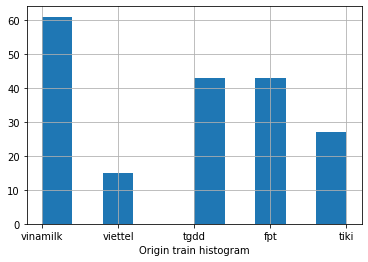

In [8]:
hist = train_df['Company'].hist()
hist.set_xlabel('Origin train histogram')

Text(0.5, 0, 'Origin val histogram')

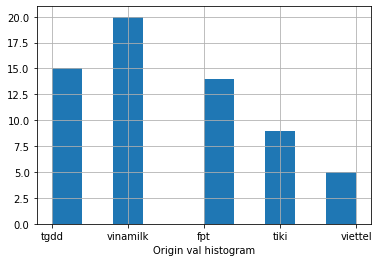

In [9]:
hist = val_df['Company'].hist()
hist.set_xlabel('Origin val histogram')

Text(0.5, 0, 'Origin test histogram')

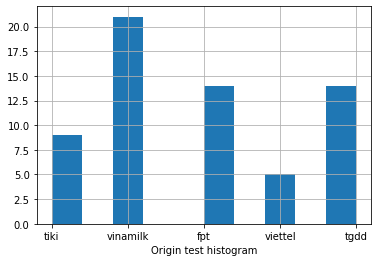

In [10]:
hist = test_df['Company'].hist()
hist.set_xlabel('Origin test histogram')

In [11]:
origin_str = train_df['File name'].str.cat(sep='|')
augmented_train_df = train_df.append(all_companies_df[all_companies_df['Origin'].str.match(origin_str)])
origin_str = val_df['File name'].str.cat(sep='|')
augmented_val_df = val_df.append(all_companies_df[all_companies_df['Origin'].str.match(origin_str)])
origin_str = test_df['File name'].str.cat(sep='|')
augmented_test_df = test_df.append(all_companies_df[all_companies_df['Origin'].str.match(origin_str)])

Text(0.5, 0, 'Augmented train histogram')

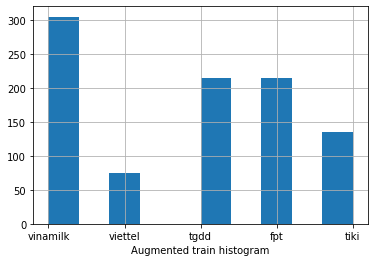

In [12]:
hist = augmented_train_df['Company'].hist()
hist.set_xlabel('Augmented train histogram')

Text(0.5, 0, 'Augmented val histogram')

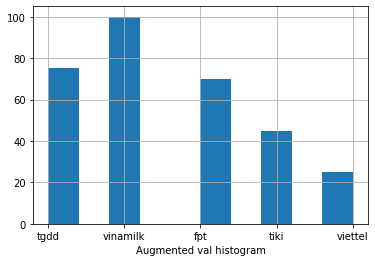

In [13]:
hist = augmented_val_df['Company'].hist()
hist.set_xlabel('Augmented val histogram')

Text(0.5, 0, 'Augmented test histogram')

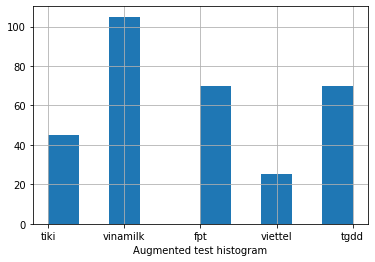

In [14]:
hist = augmented_test_df['Company'].hist()
hist.set_xlabel('Augmented test histogram')

# Tăng cường thêm dữ liệu của lớp tiki

In [15]:
def augment_data_from_file_name_of_tiki(row, in_dir, out_dir, index=0):
  ext = row['File name'].split('.')[-1]
  img = io.imread(os.path.join(in_dir, row['File name']))
  noised_img = util.random_noise(img, mode='gaussian', var=random.uniform(0.005, 0.05))
  io.imsave(os.path.join(out_dir, f'logo_{index+row.name}.{ext}'), util.img_as_ubyte(noised_img))
  return [f'augmented_logos/logo_{index+row.name}.{ext}', 'tiki']

In [16]:
train_tiki_df = augmented_train_df[augmented_train_df['Company'] == 'tiki']
val_tiki_df = augmented_val_df[augmented_val_df['Company'] == 'tiki']
test_tiki_df = augmented_test_df[augmented_test_df['Company'] == 'tiki']

In [17]:
augmented_train_tiki_sr = train_tiki_df.reset_index().apply(augment_data_from_file_name_of_tiki, args=(logo_dir, augmented_logo_dir, index), axis=1)
index += len(augmented_train_tiki_sr)

augmented_val_tiki_sr = val_tiki_df.reset_index().apply(augment_data_from_file_name_of_tiki, args=(logo_dir, augmented_logo_dir, index), axis=1)
index += len(augmented_val_tiki_sr)

augmented_test_tiki_sr = test_tiki_df.reset_index().apply(augment_data_from_file_name_of_tiki, args=(logo_dir, augmented_logo_dir, index), axis=1)
index += len(augmented_test_tiki_sr)

/home/vinhloi/anaconda3/envs/ds/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


# Tăng cường thêm dữ liệu của lớp viettel

In [18]:
def augment_data_from_file_name_of_viettel(row, in_dir, out_dir, index=0):
  ext = row['File name'].split('.')[-1]
  img = io.imread(os.path.join(in_dir, row['File name']))
  noised_img = util.random_noise(img, mode='gaussian', var=random.uniform(0.005, 0.05))
  horizontal_resized_img = transform.resize(img, (img.shape[0], int(img.shape[1] * random.uniform(1.2, 2.5))))
  vertical_resized_img = transform.resize(img, (int(img.shape[0] * random.uniform(1.2, 2.5)), img.shape[1]))

  io.imsave(os.path.join(out_dir, f'logo_{index+row.name*3}.{ext}'), util.img_as_ubyte(noised_img))
  io.imsave(os.path.join(out_dir, f'logo_{index+row.name*3+1}.{ext}'), util.img_as_ubyte(horizontal_resized_img))
  io.imsave(os.path.join(out_dir, f'logo_{index+row.name*3+2}.{ext}'), util.img_as_ubyte(vertical_resized_img))

  return [[f'augmented_logos/logo_{x}.{ext}', 'viettel'] for x in range(index+row.name*3, index+row.name*3+3)]

In [19]:
train_viettel_df = augmented_train_df[augmented_train_df['Company'] == 'viettel']
val_viettel_df = augmented_val_df[augmented_val_df['Company'] == 'viettel']
test_viettel_df = augmented_test_df[augmented_test_df['Company'] == 'viettel']

In [20]:
augmented_train_viettel_sr = train_viettel_df.reset_index().apply(augment_data_from_file_name_of_viettel, args=(logo_dir, augmented_logo_dir, index), axis=1)
index += len(augmented_train_viettel_sr)*3

augmented_val_viettel_sr = val_viettel_df.reset_index().apply(augment_data_from_file_name_of_viettel, args=(logo_dir, augmented_logo_dir, index), axis=1)
index += len(augmented_val_viettel_sr)*3

augmented_test_viettel_sr = test_viettel_df.reset_index().apply(augment_data_from_file_name_of_viettel, args=(logo_dir, augmented_logo_dir, index), axis=1)
index += len(augmented_test_viettel_sr)*3

# Final datset and histogram

In [21]:
final_train_df = augmented_train_df.append(pd.DataFrame(augmented_train_tiki_sr.tolist(), columns=['File name', 'Company']), sort=True)
final_val_df = augmented_val_df.append(pd.DataFrame(augmented_val_tiki_sr.tolist(), columns=['File name', 'Company']), sort=True)
final_test_df = augmented_test_df.append(pd.DataFrame(augmented_test_tiki_sr.tolist(), columns=['File name', 'Company']), sort=True)

In [22]:
final_train_df = final_train_df.append(pd.DataFrame(augmented_train_viettel_sr.explode().tolist(), columns=['File name', 'Company']), sort=True)
final_val_df = final_val_df.append(pd.DataFrame(augmented_val_viettel_sr.explode().tolist(), columns=['File name', 'Company']), sort=True)
final_test_df = final_test_df.append(pd.DataFrame(augmented_test_viettel_sr.explode().tolist(), columns=['File name', 'Company']), sort=True)

Text(0.5, 0, 'Final train histogram')

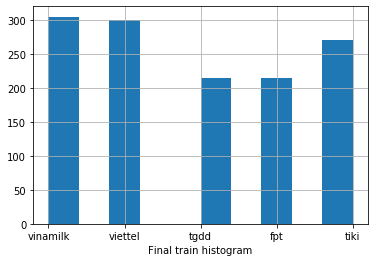

In [23]:
hist = final_train_df['Company'].hist()
hist.set_xlabel('Final train histogram')

Text(0.5, 0, 'Final validation histogram')

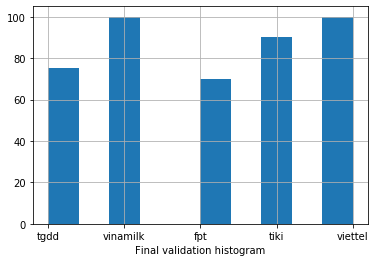

In [24]:
hist = final_val_df['Company'].hist()
hist.set_xlabel('Final validation histogram')

Text(0.5, 0, 'Final test histogram')

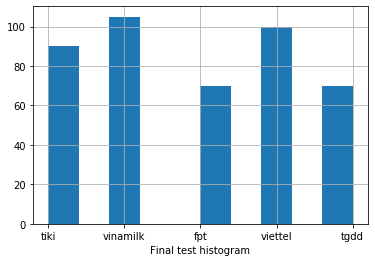

In [25]:
hist = final_test_df['Company'].hist()
hist.set_xlabel('Final test histogram')

Text(0.5, 0, 'Final dataset histogram')

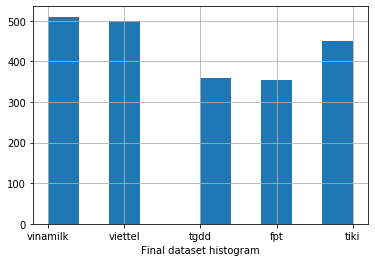

In [26]:
final_df = final_train_df.append(final_test_df.append(final_val_df))
hist = final_df['Company'].hist()
hist.set_xlabel('Final dataset histogram')

In [27]:
final_train_df[['File name', 'Company']].to_csv('./dataset/train.csv', index=False, header=True)
final_val_df[['File name', 'Company']].to_csv('./dataset/val.csv', index=False, header=True)
final_test_df[['File name', 'Company']].to_csv('./dataset/test.csv', index=False, header=True)

train_df[['File name', 'Company']].to_csv('./dataset/origin_train.csv', index=False, header=True)
val_df[['File name', 'Company']].to_csv('./dataset/origin_val.csv', index=False, header=True)
test_df[['File name', 'Company']].to_csv('./dataset/origin_test.csv', index=False, header=True)